In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading and Preprocessing

## Load the Data

Load the bixi trip history data and combine it into a single Pandas DataFrame.

Assumes that all *.csv* files are inside the *data/raw/* directory relative to the notebook.

**Note**: importing uses string *dtype* for station IDs because there is one station that does not have an integer ID. Alternatively, we could just find the station in the data files and remove it.

In [5]:
import glob

# Get all raw data .csv files excluding the station files
filenames = glob.glob('data/raw/OD_*.csv')

# Load each file and merge into a single data_frame
bixi_df = pd.concat(pd.read_csv(f, index_col='start_date', 
                                   parse_dates=['start_date', 'end_date'],
                                   dtype={'start_station_code': str, 'end_station_code': str}) 
                                   for f in sorted(filenames))

In [6]:
# Preview the dataframe
display(bixi_df)

,start_station_code,end_date,end_station_code,duration_sec,is_member
start_date,,,,,
2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1
2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1
2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1
2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1
2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1
...,...,...,...,...,...
2020-11-16 04:49:38,7073,2020-11-16 04:56:23,6209,404,1
2020-11-16 04:51:27,6154,2020-11-16 04:55:17,7035,230,1
2020-11-16 04:53:24,6108,2020-11-16 05:02:51,6017,566,1


## Get Station Trip History Data

### Group by station

We can group the data by either start or end station in order to create separate time-series for each station:
* Grouping by start station allows us to estimate overall bike demand using the number of outgoing trips from the station
* Grouping by end station allows us to estimate overall dock demand using the number of incoming trips to the station

**Note**: the following steps are only done for bike demand (start station). Working with dock demand will follow the same pattern.

In [18]:
# Group the data by start station
bike_demand_gb = bixi_df.groupby('start_station_code')

### Find most popular station

In [20]:
# Print stations sorted according to the total number of trips
display("Group sizes:", bike_demand_gb.size().sort_values(ascending=False).head())

'Group sizes:'

start_station_code
6184    280471
6100    260342
6064    218736
6136    217916
6221    204961
dtype: int64

The most popular station has ID *6184*, let's find what it is.

In [21]:
# Load most recent station data
stations_df = pd.read_csv('data/raw/stations.csv', index_col='code')

# Print most popular station data
display(stations_df.loc[6184])

name         Métro Mont-Royal (Rivard / du Mont-Royal)
latitude                                     45.524673
longitude                                    -73.58255
Name: 6184, dtype: object

### Extract most popular section data

In [35]:
# Get Metro Mont-Royal data
station_demand = bixi_gb.get_group('6184')

# Check for any missing values
print("Number of missing values:", station_demand.isnull().values.sum())

# Preview the data
display(station_demand.head())

Number of missing values: 0


,start_station_code,end_date,end_station_code,duration_sec,is_member
start_date,,,,,
2014-04-15 06:32:00,6184,2014-04-15 06:38:00,6152,411,1
2014-04-15 07:53:00,6184,2014-04-15 08:02:00,6015,517,1
2014-04-15 08:12:00,6184,2014-04-15 08:27:00,6078,912,1
2014-04-15 08:13:00,6184,2014-04-15 08:17:00,6157,231,1
2014-04-15 08:17:00,6184,2014-04-15 08:22:00,6221,268,1


## Resample The Data

In order to make forecasts, we will downsample the data to 3 hour intervals, totalling to 8 samples per day.

**Notes**:
* Other sample sizes are possible, for example we could use daily frequency
* When downsampling, properties become hard to aggregate meaningfully. For trip duration we could do something like total duration within the window and for membership we could do something like the percentage of members to non-members. However, we would need to make sure that these would be meaningful and we have a way to use them for forecasting.
* For now, only the time interval and the number of trips within that interval are left at this stage.

In [36]:
# Add the trip_count column
station_demand.insert(0, 'trip_count', 1)

# Select only the relevant columns (index + trip count)
station_demand = station_demand[['trip_count']]

# Resample to 3H frequency
station_demand = station_demand.resample('3H').sum()

# Preview the resampled data
display(station_demand.head(n=9))

,trip_count
start_date,
2014-04-15 06:00:00,10
2014-04-15 09:00:00,1
2014-04-15 12:00:00,0
2014-04-15 15:00:00,8
2014-04-15 18:00:00,6
2014-04-15 21:00:00,6
2014-04-16 00:00:00,1
2014-04-16 03:00:00,0
2014-04-16 06:00:00,8


# Analysis and Visualization

In [108]:
# Statsmodels for decomposition and autocorrelation
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Demand history plots

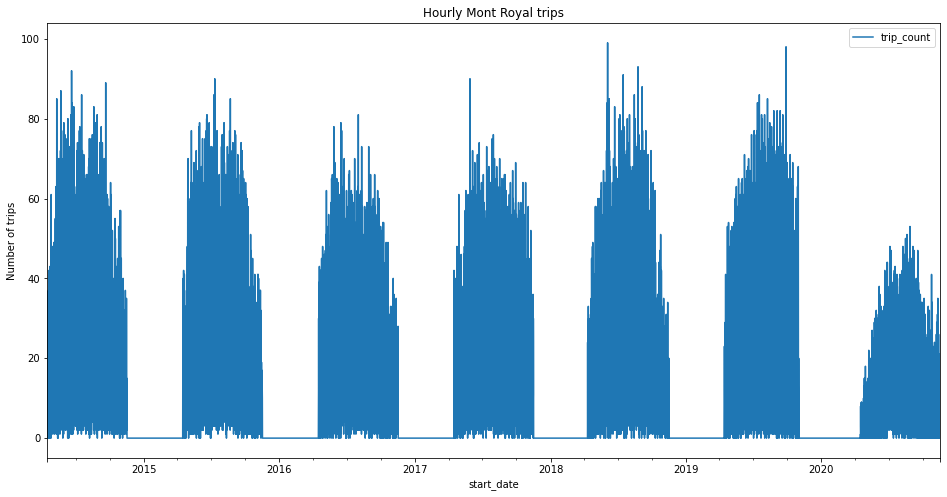

In [39]:
# Hourly plot (3-hour intevals)
station_demand.plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

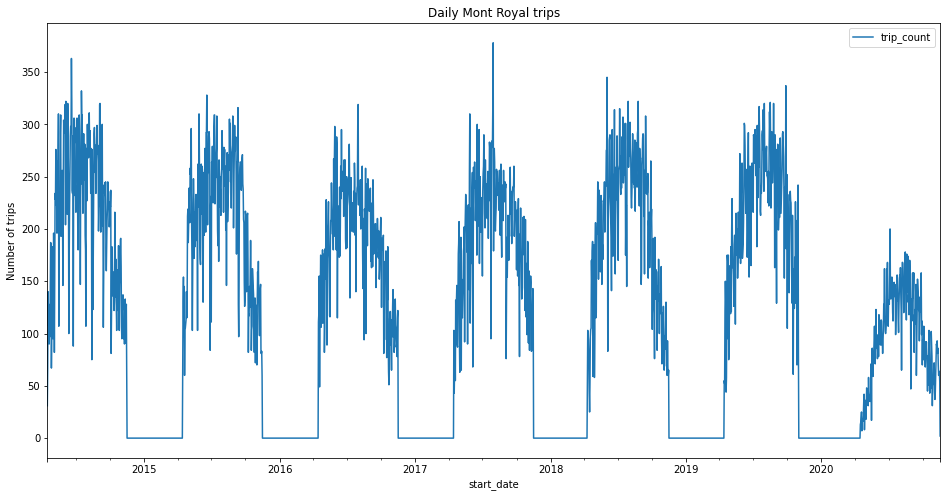

In [43]:
# Daily plot
station_demand.resample('D').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily Mont Royal trips')
plt.show()

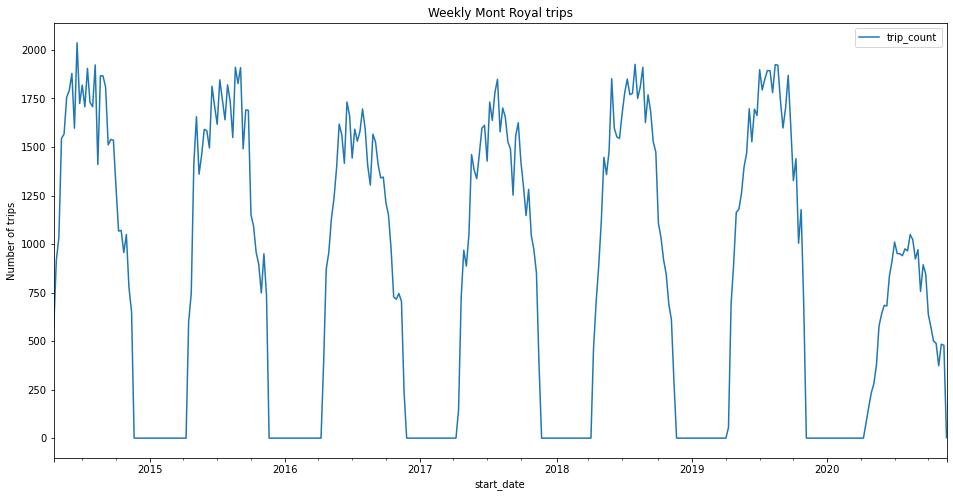

In [44]:
# Weekly plot
station_demand.resample('W').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Weekly Mont Royal trips')
plt.show()

As we can see, there is a very clear yearly periodicity on the data.

Let's zoom in on a particular year/month and examine shorter terms history.

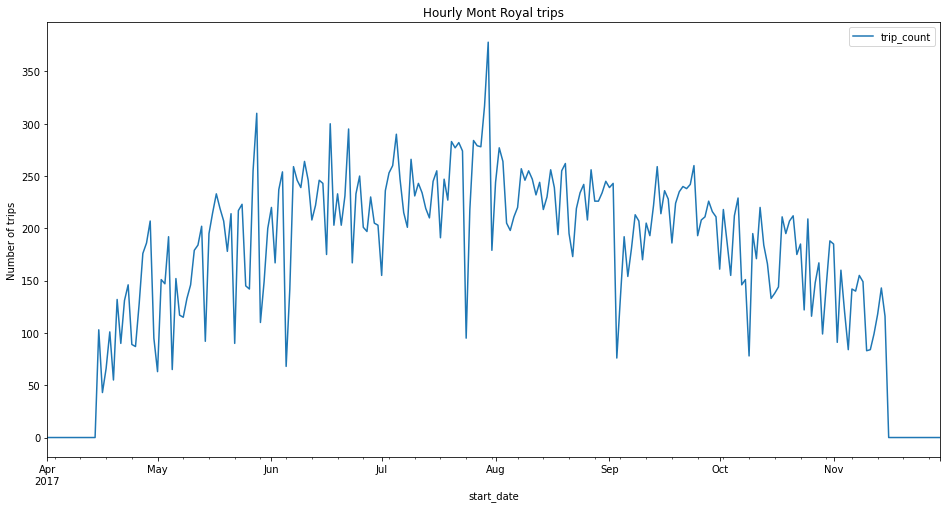

In [52]:
# Daily plot for 2017
station_demand.loc['2017-04':'2017-11'].resample('D').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

There is a clear pattern within this year, with the demand steadily increasing until the peak in late July/early August and then decreasing.

Let's look at the data for one month and the weekday data.

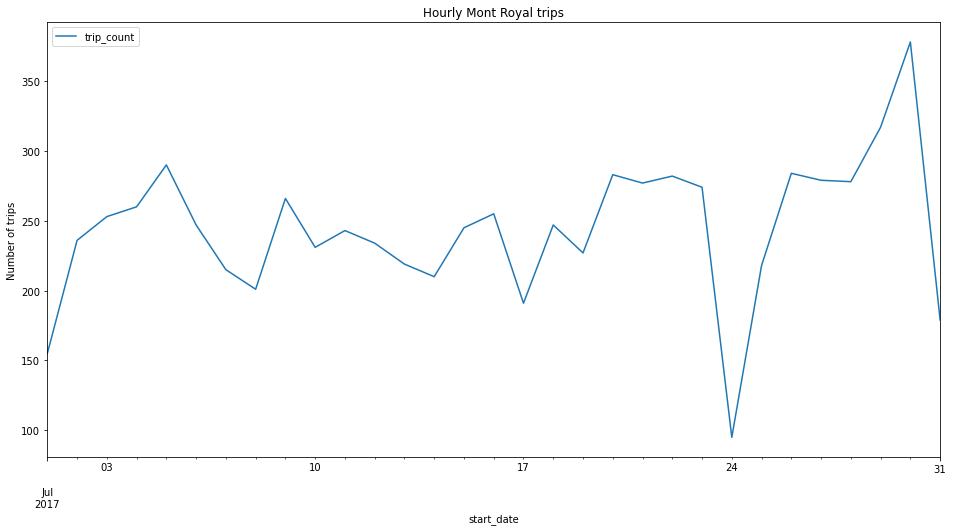

In [54]:
# Daily plot for July 2017
station_demand.loc['2017-07'].resample('D').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

In [56]:
# Copy July demand into a new data frame
july_demand = station_demand.loc['2017-07'].resample('D').sum().copy()

# Add weekdays to each sample
july_demand ['weekday'] = july_demand.index.day_name()

weekday
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

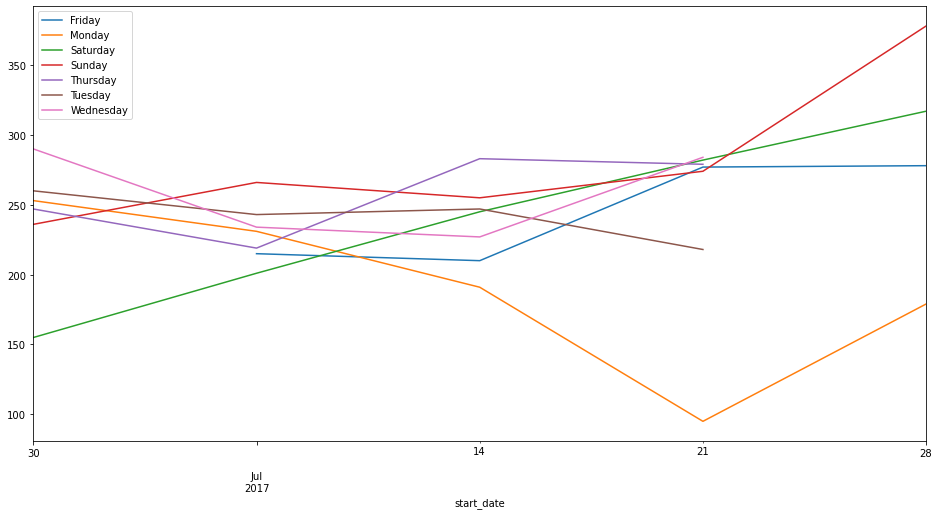

In [105]:
# Group by weekday and plot
fig, ax = plt.subplots(figsize=(16, 8))
july_demand.groupby('weekday').apply(lambda x: x['trip_count'].plot(x=x.index, ax=ax, legend=True, label=x['weekday'][0]))

**Note**: for some reason the a-axis actually evently spaces all points and does not use timestamps - need to find a way to arrange the plots properly.

## Seasonal Decomposition

Decompose the data into trend, periodic and noise components.

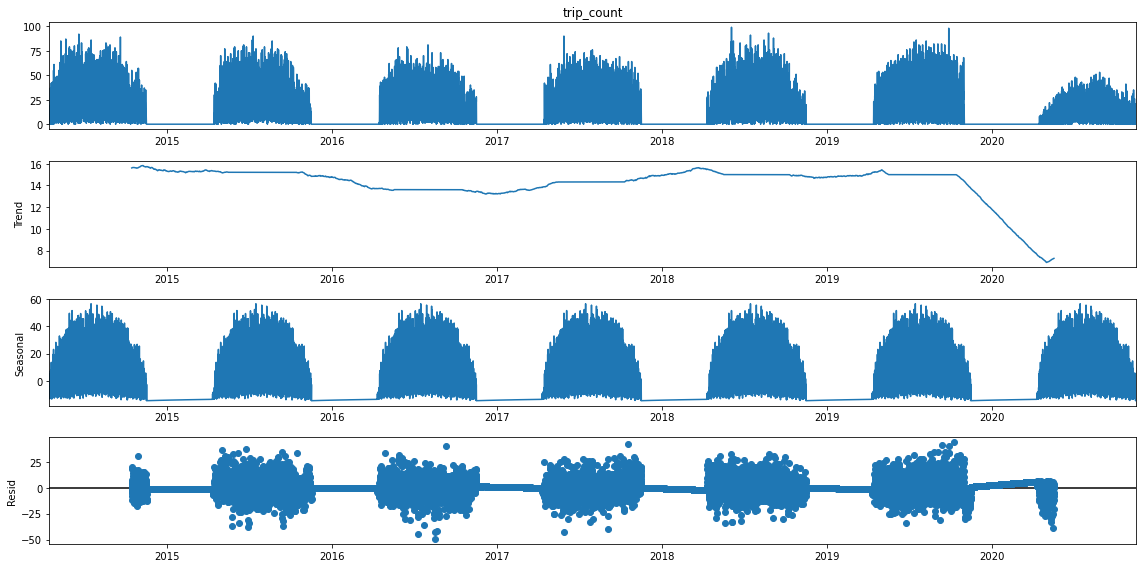

In [111]:
# Configure the period to be annual
samples_per_day = 8
days_per_year = 365
period = samples_per_day * days_per_year

decomposed_trip_data = sm.tsa.seasonal_decompose(station_demand["trip_count"], period=period)
figure = decomposed_trip_data.plot()
plt.show()

A few observations:
* The trend is relatively constant throughout the years with a large dip at the end of 2019 (missing November data) and into 2020 (pandemic)
* There a strong overall yearly periodic component
* There is still a significant about of noise among individual samples

## Autocorrelation

Let's see what the autocorrelation looks like with up to 1 year lag.

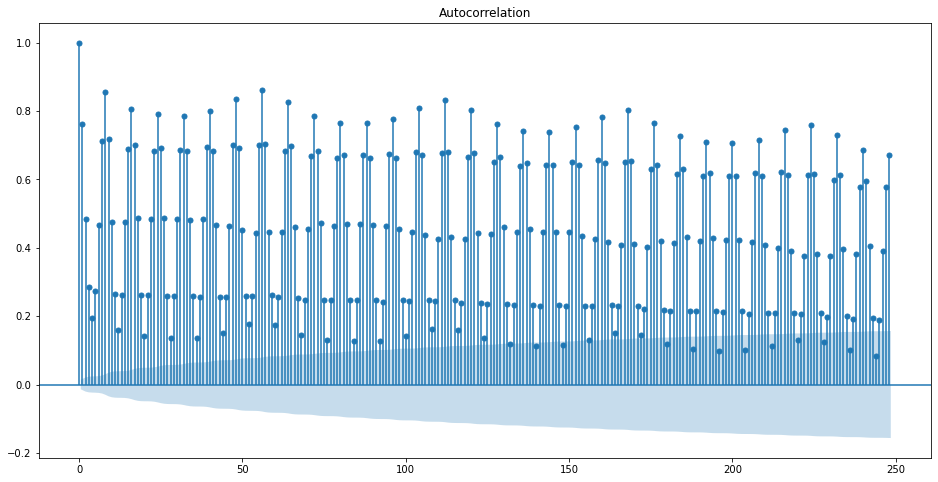

In [117]:
# Autocorrelation with up to month lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=248)
plt.show()

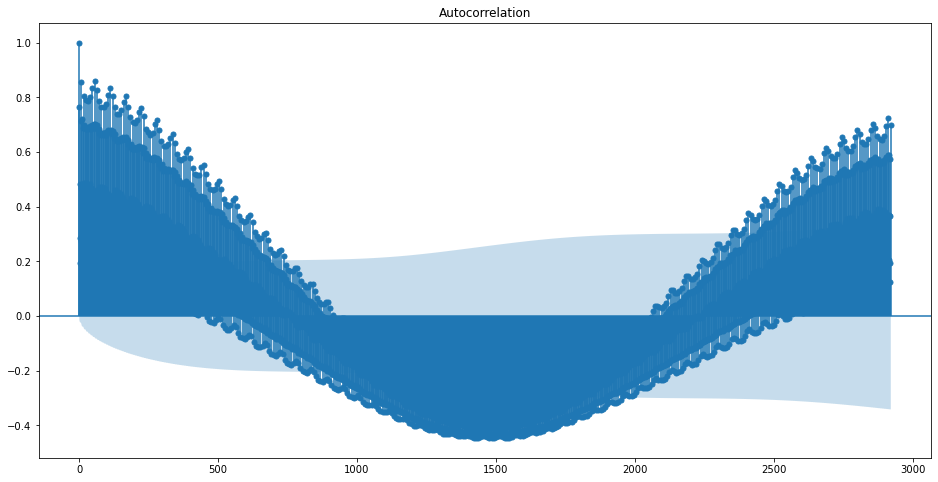

In [120]:
# Autocorrelation with up to year lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=period)
plt.show()

As we can see, there is a statistically significant autocorrelation at each level:
* Previous day/week/month usage is generally correlated with the next
* Previous year usage is generally correlated with the next

# Dummy baselines

We will use **sktime** library to implement our forecasting baselines.

In [122]:
# Naive forecaster
from sktime.forecasting.naive import NaiveForecaster

# Prophet forecaster
from sktime.forecasting.fbprophet import Prophet

# Error metrics
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

## Data Splitting

Split the data into training and test set.
* Training set: from 2014 to 2018 (inclusive)
* Test set: 2019

Since the main low-frequency data periodicity is yearly, it makes sense to do a yearly split. This split gives approximately a 5 to 1 training to test split ratio (about 83:17).

**Notes**: 
* 2020 was excluded due to overall trend dip because of the pandemic, as can be seen in the visualizations.
* 2019 is missing the data for November so using it as test data will lead to large errors for November. We might want to either use 2018 (4:1 split) as test data or somehow fill missing data for 2019.

In [124]:
# Split station data into training and test set
demand_train = station_demand['2014':'2018']
demand_test  = station_demand['2019':'2019']

## Seasonal Naive Baseline 

In [125]:
# Define a helper function to plot the prediction and calculate error
def eval_forecast(forecaster, fh, y_true):
    # Make predictions 
    y_pred = forecaster.predict(fh)

    # Downsample data to daily and plot
    ax = demand_test.resample('D').sum().plot(figsize=(16, 8))
    y_pred.resample('D').sum().plot(ax=ax)

    # Compute RMSE
    print("RMSE:", mean_squared_error(y_true, y_pred, square_root=True))
    # Compute Symmetric Mean Absolute Percentate Error
    print("SMAPE:", mean_absolute_percentage_error(y_true, y_pred, symmetric=True))

In [126]:
# Configure forecast parameters

# Configure the seasonal period to be yearly
samples_per_day = 8
days_per_year = 365
seasonal_period = samples_per_day * days_per_year

# Configure the forecating horizon to be the length of the test set
fh = np.arange(1, len(demand_test)+1)

RMSE: 11.128914579869296
SMAPE: 0.40903619471071584


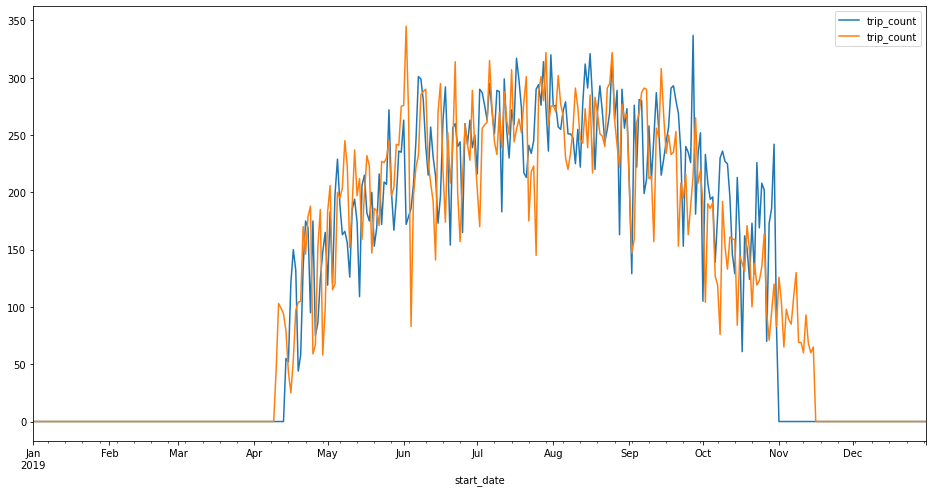

In [127]:
# Forecast using the seasonal naive random walk forecast
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate the forecast
eval_forecast(forecaster, fh, demand_test)

RMSE: 10.139890623143579
SMAPE: 0.3963479784562324


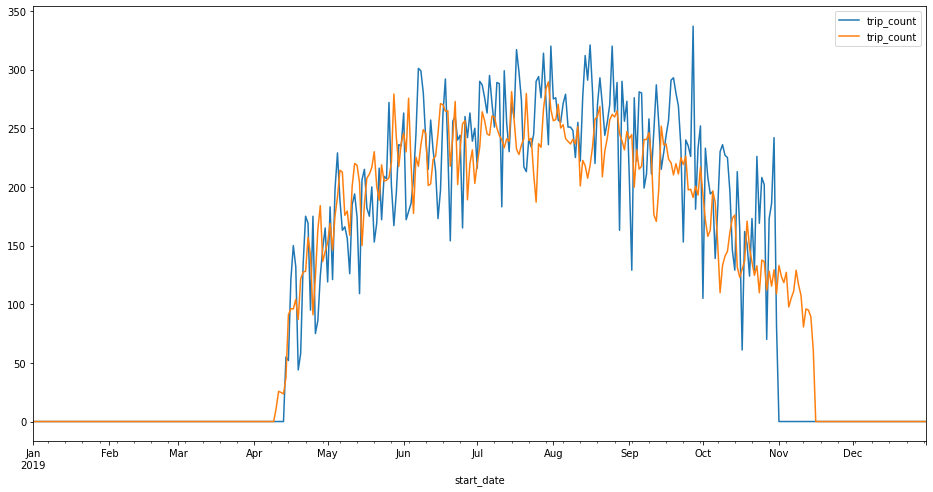

In [128]:
# Forecast using the seasonal naive mean forecast
forecaster = NaiveForecaster(strategy="mean", sp = 2920) 
forecaster.fit(demand_train)

# Evaluate and plot the forecast
eval_forecast(forecaster, fh, demand_test)

## Prophet Baseline

TBA